# Example 3: Three plants
_______

This illustrates storage impact in a 3 power plant/2 time slot system with constant supply curves.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import symenergy.core.model as model
import symenergy.evaluator.evaluator as evaluator

pd.options.mode.chained_assignment = None

## Initialize model
The model structure is initialized.

Parameter values are insignificant at this stage as long as they are !=None. They represent default values and define the model structure.

`Model.generate_solve()` loads the solved model results from the corresponding pickle file if a model with the same structure (variables and multipliers) has been solved before.

`nthread` is the number of cores used for parallelized solving.

In [4]:
m = model.Model(curtailment=True, nthreads=7)

m.add_slot(name='day', load=4.5, vre=3)
m.add_slot(name='night', load=5, vre=0.5)

m.add_plant(name='n', vc0=1, vc1=None, slots=m.slots, capacity=3, fcom=10, cap_ret=True)
m.add_plant(name='c', vc0=1, vc1=1, slots=m.slots, capacity=3, fcom=10, cap_ret=True)
m.add_plant(name='g', vc0=2, vc1=1, slots=m.slots)

m.add_storage(name='phs', eff=0.75, slots=m.slots, capacity=0.5, energy_capacity=1,
              slots_map={'day': 'chg', 'night': 'dch'})

m.generate_solve()


Loading from pickle file /mnt/data/Dropbox/SHARED_REPOS/symenergy/cache/5796EF37D4C6.pickle.


## Initialize evaluator instance, set model parameters and parameter sweep values.
The model results are evaluated for all combinations of the iterables' values in the `x_vals` argument.

The `Evaluator.df_x_vals` instance attribute is modified after initialization to
* filter model runs
* set the storage energy capacity `E_phs` in dependence on the efficiency `eff_phs` (i.e. the storage type)

In [12]:
m.slots['day'].l.value = 10000
m.slots['night'].l.value = 8000
m.slots['day'].vre.value = 1
m.slots['night'].vre.value = 0.1

vre_day = 1
vre_night = 0.1
tot_l = m.slots['day'].l.value + m.slots['night'].l.value

m.slots['day'].vre.value = vre_day / (vre_day + vre_night) * tot_l
m.slots['night'].vre.value = vre_night / (vre_day + vre_night) * tot_l

m.comps['n'].C.value = 3500
m.comps['c'].C.value = 3500


list_params = [
 {
  "fc_new": 7.4,
  "pp": "c",
  "vc_tot_max": 32.6,
  "vc_tot_min": 21.4
 },
 {
  "fc_new": 4.7,
  "pp": "g",
  "vc_tot_max": 101.4,
  "vc_tot_min": 51.4
 },
 {
  "fc_new": 9.1,
  "pp": "n",
  "vc_tot_max": 9.6,
  "vc_tot_min": 9.6
 }
]
dict_params = {par['pp']: par for par in list_params}
dict_params = {key: {par: val for par, val in params.items() if not par == 'pp'}
               for key, params in dict_params.items()}
dict_params = {key: val for key, val in dict_params.items()}

for pp, params in dict_params.items():

    fcom, vcmax, vcmin = params.values()

    ref_cap = (m.comps[pp].C.value if hasattr(m.comps[pp], 'C')
                                   else m.slots['day'].l.value)

    m.comps[pp].vc0.value = vcmin
    if hasattr(m.comps[pp], 'vc1'):
        m.comps[pp].vc1.value = (vcmax - vcmin) / ref_cap
    if hasattr(m.comps[pp], 'fcom'):
        m.comps[pp].fcom.value = fcom

dd_75 = 14

phs_C_max = m.slots['day'].l.value * 0.5
vre_scale_max = m.slots['day'].vre.value

x_vals = {m.vre_scale: np.linspace(0, 1, 21),
          m.comps['phs'].C: [500, 2500, 0],
          m.comps['phs'].E: [500, 2500, 0]
          }

ev = evaluator.Evaluator(m, x_vals, drop_non_optimum=True)

ev.df_x_vals = ev.df_x_vals.loc[ev.df_x_vals.C_phs == ev.df_x_vals.E_phs]
ev.df_x_vals.loc[:, 'E_phs'] *= dd_75/12

print(ev.df_x_vals.head(10))
print('Length: ', len(ev.df_x_vals))

   vre_scale  C_phs        E_phs
0       0.00    500   583.333333
1       0.00   2500  2916.666667
2       0.00      0     0.000000
3       0.05    500   583.333333
4       0.05   2500  2916.666667
5       0.05      0     0.000000
6       0.10    500   583.333333
7       0.10   2500  2916.666667
8       0.10      0     0.000000
9       0.15    500   583.333333
Length:  63


## Generate functions from the symenergy results
This evaluates the results using the fixed parameters and returns functions with arguments corresponding to the columns in the `Evaluator.df_x_vals` table.

**Note: Takes a while.**

In [13]:
ev.get_evaluated_lambdas(skip_multipliers=True)

Extracting solution for n_C_ret_None...substituting...lambdify...done.
Extracting solution for n_p_day...substituting...lambdify...done.
Extracting solution for n_p_night...substituting...lambdify...done.
Extracting solution for c_C_ret_None...substituting...lambdify...done.
Extracting solution for c_p_day...substituting...lambdify...done.
Extracting solution for c_p_night...substituting...lambdify...done.
Extracting solution for g_p_day...substituting...lambdify...done.
Extracting solution for g_p_night...substituting...lambdify...done.
Extracting solution for phs_e_None...substituting...lambdify...done.
Extracting solution for phs_p_day...substituting...lambdify...done.
Extracting solution for phs_p_night...substituting...lambdify...done.
Extracting solution for curt_p_day...substituting...lambdify...done.
Extracting solution for curt_p_night...substituting...lambdify...done.
Extracting solution for pi_load_day...substituting...lambdify...done.
Extracting solution for pi_load_night..

## Evaluate results for all entries of the `Evaluator.df_x_vals table`
**Note: Depending on the size of the model and the `df_x_vals` table this takes a while.**

In [14]:
ev.expand_to_x_vals(verbose=True)

0 {'vre_scale': 0.0, 'C_phs': 500.0, 'E_phs': 583.3333333333334} -> 37.138548135757446
0 {'vre_scale': 0.0, 'C_phs': 500.0, 'E_phs': 583.3333333333334} -> 39.425577878952026
1 {'vre_scale': 0.0, 'C_phs': 2500.0, 'E_phs': 2916.666666666667} -> 38.035043716430664
2 {'vre_scale': 0.0, 'C_phs': 0.0, 'E_phs': 0.0} -> 37.34807252883911
3 {'vre_scale': 0.05, 'C_phs': 500.0, 'E_phs': 583.3333333333334} -> 37.5744047164917
4 {'vre_scale': 0.05, 'C_phs': 2500.0, 'E_phs': 2916.666666666667} -> 37.027801513671875
5 {'vre_scale': 0.05, 'C_phs': 0.0, 'E_phs': 0.0} -> 40.55328440666199
6 {'vre_scale': 0.1, 'C_phs': 500.0, 'E_phs': 583.3333333333334} -> 41.32857966423035
7 {'vre_scale': 0.1, 'C_phs': 2500.0, 'E_phs': 2916.666666666667} -> 38.00553035736084
8 {'vre_scale': 0.1, 'C_phs': 0.0, 'E_phs': 0.0} -> 38.51243829727173
9 {'vre_scale': 0.15000000000000002, 'C_phs': 500.0, 'E_phs': 583.3333333333334} -> 35.15053629875183
10 {'vre_scale': 0.15000000000000002, 'C_phs': 2500.0, 'E_phs': 2916.66666666

## Add additional columns to the `Evaluator.df_exp` table
Variables are not indexed by time slot names. The `Evaluator.map_func_to_slot` method expands the `Evaluator.df_exp` table by additional columns with variable names and time slots names.

In [15]:
ev.map_func_to_slot()

map_func_to_slot


## Build supply table `Evaluator.df_bal`
This includes the demand to the result demand and adjusts the signs, such that demand, charging, and curtailment are negative. 


In [16]:
ev.build_supply_table()

print(ev.df_bal.head(5))

   C_phs       E_phs                                         const_comb  \
0  500.0  583.333333  act_lb_n_pos_p_day=0, act_lb_n_pos_p_night=0, ...   
1  500.0  583.333333  act_lb_n_pos_p_day=0, act_lb_n_pos_p_night=0, ...   
2  500.0  583.333333  act_lb_n_pos_p_day=0, act_lb_n_pos_p_night=0, ...   
3  500.0  583.333333  act_lb_n_pos_p_day=0, act_lb_n_pos_p_night=0, ...   
4  500.0  583.333333  act_lb_n_pos_p_day=0, act_lb_n_pos_p_night=0, ...   

                    func func_no_slot   lambd    slot  vre_scale  
0  n_C_ret_None_lam_plot      n_C_ret     0.0  global        0.0  
1       n_p_day_lam_plot          n_p  3500.0     day        0.0  
2     n_p_night_lam_plot          n_p  3500.0   night        0.0  
3  c_C_ret_None_lam_plot      c_C_ret     0.0  global        0.0  
4       c_p_day_lam_plot          c_p  3500.0     day        0.0  


## Impact of storage on peak, mid, and baseload production

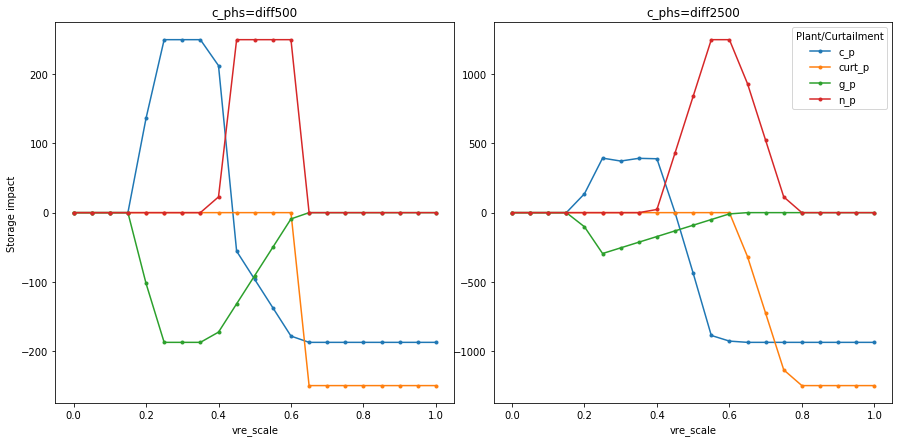

In [47]:
df = ev.df_exp
df = df.loc[df.func.str.contains('n_p_|g_p_|curt|c_p_')
           & df.is_optimum.isin([True])
           & -df.slot.isin(['global'])]


dfdiff = df.pivot_table(index=[x for x in ev.x_name
                               if not x in ['E_phs', 'C_phs']] + ['func_no_slot'],
                        values='lambd', columns='C_phs')
for c_phs in [2500, 500]:
    dfdiff['diff%d'%c_phs] = dfdiff[c_phs] - dfdiff[0]
dfdiff.head(10)


dfdiff = dfdiff[['diff2500', 'diff500']].stack().rename('diff').reset_index()

dfpv = dfdiff.pivot_table(index=['C_phs', 'vre_scale'],
                          values='diff',
                          columns=['func_no_slot'])

list_c_phs = dfpv.index.get_level_values('C_phs').unique()

fig, axarr = plt.subplots(1, len(list_c_phs), sharey=False, 
                          gridspec_kw={'wspace': 0.1,},
                          figsize=(15,7))

for nc_phs, c_phs in enumerate(reversed(list_c_phs)):

    ax = axarr[nc_phs]
    dfpv.loc[(c_phs)].plot(ax=ax, legend=False, marker='.',
                           use_index=True, stacked=False, width=1)

    ax.set_title('c_phs=%s'%(c_phs))

axarr[0].set_ylabel('Storage impact') 
leg = ax.legend(title='Plant/Curtailment')